In [ ]:
pip install yfinance --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.4/118.4 kB 2.3 MB/s eta 0:00:00
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.61
    Uninstalling yfinance-0.2.61:
      Successfully uninstalled yfinance-0.2.61


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import os

In [ ]:
tickers = [
    'ACES.JK', 'ADMR.JK', 'ADRO.JK', 'AKRA.JK', 'AMMN.JK', 'AMRT.JK', 'ANTM.JK',
    'ARTO.JK', 'ASII.JK', 'BBCA.JK', 'BBNI.JK', 'BBRI.JK', 'BBTN.JK', 'BMRI.JK',
    'BRIS.JK', 'BRPT.JK', 'CPIN.JK', 'CTRA.JK', 'ESSA.JK', 'EXCL.JK', 'GOTO.JK',
    'ICBP.JK', 'INCO.JK', 'INDF.JK', 'INKP.JK', 'ISAT.JK', 'ITMG.JK', 'JPFA.JK',
    'JSMR.JK', 'KLBF.JK', 'MAPA.JK', 'MAPI.JK', 'MBMA.JK', 'MDKA.JK', 'MEDC.JK',
    'PGAS.JK', 'PGEO.JK', 'PTBA.JK', 'SIDO.JK', 'SMGR.JK', 'SMRA.JK', 'TLKM.JK',
    'TOWR.JK', 'UNTR.JK', 'UNVR.JK'
]

In [ ]:
# Folder Google Drive untuk simpan plot
# plot_dir = '/content/drive/MyDrive/TA/colab2_svm'
# os.makedirs(plot_dir, exist_ok=True)

In [ ]:
# Range Data
end_date = datetime(2024, 12, 31)
start_date = datetime(2020, 1, 1)

# Download dari yfinance
data_frames = []
for ticker in tickers:
    stock = yf.Ticker(ticker)
    df = stock.history(start=start_date, end=end_date)
    df = df[['Close']].rename(columns={'Close': ticker})
    data_frames.append(df)

# Combine df
combined_df = pd.concat(data_frames, axis=1)

# Simpan ke csv
combined_df.to_csv("LQ45_stocks_close_data20-24.csv", index_label='Date')
print("Data has been saved to LQ45_stocks_close_data.csv")

Data has been saved to LQ45_stocks_close_data.csv


In [ ]:
data = pd.read_csv('LQ45_stocks_close_data20-24.csv', parse_dates=['Date'], index_col='Date')

# Jumlah saham dan baris sebelum filter
print(f"📊 Sebelum filter:")
print(f"Jumlah saham (kolom): {data.shape[1]}")
print(f"Jumlah tanggal (baris): {data.shape[0]}")
print("\nJumlah nilai null per saham:")
print(data.isnull().sum())

threshold = 0.9 * len(data)
data = data.loc[:, data.notnull().sum() > threshold]

data.fillna(method='ffill', inplace=True)
data.dropna(inplace=True)

# Jumlah saham dan baris setelah filter
print(f"\n✅ Setelah filter:")
print(f"Jumlah saham (kolom): {data.shape[1]}")
print(f"Jumlah tanggal (baris): {data.shape[0]}")
print("\nJumlah nilai null per saham setelah filter:")
print(data.isnull().sum())

📊 Sebelum filter:
Jumlah saham (kolom): 45
Jumlah tanggal (baris): 1211

Jumlah nilai null per saham:
ACES.JK      0
ADMR.JK    489
ADRO.JK      0
AKRA.JK      0
AMMN.JK    853
AMRT.JK      0
ANTM.JK      0
ARTO.JK      0
ASII.JK      0
BBCA.JK      0
BBNI.JK      0
BBRI.JK      0
BBTN.JK      0
BMRI.JK      0
BRIS.JK      0
BRPT.JK      0
CPIN.JK      0
CTRA.JK      0
ESSA.JK      0
EXCL.JK      0
GOTO.JK    556
ICBP.JK      0
INCO.JK      0
INDF.JK      0
INKP.JK      0
ISAT.JK      0
ITMG.JK      0
JPFA.JK      0
JSMR.JK      0
KLBF.JK      0
MAPA.JK      0
MAPI.JK      0
MBMA.JK    807
MDKA.JK      0
MEDC.JK      0
PGAS.JK      0
PGEO.JK    773
PTBA.JK      0
SIDO.JK      0
SMGR.JK      0
SMRA.JK      0
TLKM.JK      0
TOWR.JK      0
UNTR.JK      0
UNVR.JK      0
dtype: int64

✅ Setelah filter:
Jumlah saham (kolom): 40
Jumlah tanggal (baris): 1211

Jumlah nilai null per saham setelah filter:
ACES.JK    0
ADRO.JK    0
AKRA.JK    0
AMRT.JK    0
ANTM.JK    0
ARTO.JK    0
ASII.JK    0
B

<ipython-input-6-1812627551>:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


In [ ]:
def preprocess_saham_for_svm(data, ticker, window_size=30):
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(data[[ticker]])

    X, y = [], []
    for i in range(window_size, len(scaled)):
        X.append(scaled[i-window_size:i, 0])
        y.append(scaled[i, 0])

    X = np.array(X)
    y = np.array(y)
    return X, y, scaler

In [ ]:
results = []
for ticker in data.columns:
    try:
        print(f"Processing {ticker}...")
        X, y, scaler = preprocess_saham_for_svm(data, ticker, window_size=30)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

        model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.01)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        y_pred_actual = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
        y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

        mse = mean_squared_error(y_test_actual, y_pred_actual)
        mae = mean_absolute_error(y_test_actual, y_pred_actual)
        rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
        harga_rata2 = np.mean(y_test_actual)
        mae_pct = (mae / harga_rata2) * 100
        rmse_pct = (rmse / harga_rata2) * 100
        r2 = r2_score(y_test_actual, y_pred_actual)

        results.append({
            'Saham': ticker,
            'Harga Rata-rata': round(harga_rata2, 2),
            'MAE': round(mae, 2),
            'MAE (%)': round(mae_pct, 2),
            'RMSE': round(rmse, 2),
            'RMSE (%)': round(rmse_pct, 2),
            'R2': r2
        })

        # Simpan data terakhir untuk visualisasi
        last_y_test_actual = y_test_actual
        last_y_pred_actual = y_pred_actual
        last_ticker = ticker

        plt.figure(figsize=(10, 5))
        plt.plot(y_test_actual, label='Aktual', color='blue')
        plt.plot(y_pred_actual, label='Prediksi (SVM)', color='orange')
        plt.title(f'Prediksi vs Aktual Harga Saham {ticker} dengan SVM')
        plt.xlabel('Hari')
        plt.ylabel('Harga')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()

        # Simpan ke folder di Google Drive
        # plt.savefig(os.path.join(plot_dir, f"plot_{ticker}.png"))
        # plt.close()


    except Exception as e:
        print(f"⚠️ Gagal memproses {ticker}: {e}")

Processing ACES.JK...
Processing ADRO.JK...
Processing AKRA.JK...
Processing AMRT.JK...
Processing ANTM.JK...
Processing ARTO.JK...
Processing ASII.JK...
Processing BBCA.JK...
Processing BBNI.JK...
Processing BBRI.JK...
Processing BBTN.JK...
Processing BMRI.JK...
Processing BRIS.JK...
Processing BRPT.JK...
Processing CPIN.JK...
Processing CTRA.JK...
Processing ESSA.JK...
Processing EXCL.JK...
Processing ICBP.JK...
Processing INCO.JK...
Processing INDF.JK...
Processing INKP.JK...
Processing ISAT.JK...
Processing ITMG.JK...
Processing JPFA.JK...
Processing JSMR.JK...
Processing KLBF.JK...
Processing MAPA.JK...
Processing MAPI.JK...
Processing MDKA.JK...
Processing MEDC.JK...
Processing PGAS.JK...
Processing PTBA.JK...
Processing SIDO.JK...
Processing SMGR.JK...
Processing SMRA.JK...
Processing TLKM.JK...
Processing TOWR.JK...
Processing UNTR.JK...
Processing UNVR.JK...


In [ ]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='MAE (%)')
print("\n=== Hasil Evaluasi Model SVM ===")
print(results_df)


=== Hasil Evaluasi Model SVM ===
      Saham  Harga Rata-rata     MAE  MAE (%)    RMSE  RMSE (%)        R2
23  ITMG.JK         24911.48  274.78     1.10  365.65      1.47  0.922346
20  INDF.JK          6558.51   73.06     1.11  106.85      1.63  0.977796
26  KLBF.JK          1507.56   19.54     1.30   25.87      1.72  0.943182
6   ASII.JK          4470.30   58.43     1.31   75.99      1.70  0.909717
7   BBCA.JK          9591.84  126.01     1.31  157.66      1.64  0.858305
14  CPIN.JK          4872.64   68.76     1.41   90.39      1.86  0.847078
33  SIDO.JK           598.72    8.65     1.44   11.32      1.89  0.974749
31  PGAS.JK          1390.29   20.75     1.49   28.82      2.07  0.981430
36  TLKM.JK          3126.50   46.58     1.49   63.69      2.04  0.971191
17  EXCL.JK          2173.61   32.83     1.51   44.64      2.05  0.752852
38  UNTR.JK         22381.88  341.10     1.52  444.33      1.99  0.959378
21  INKP.JK          8348.87  127.67     1.53  173.67      2.08  0.948588
37  

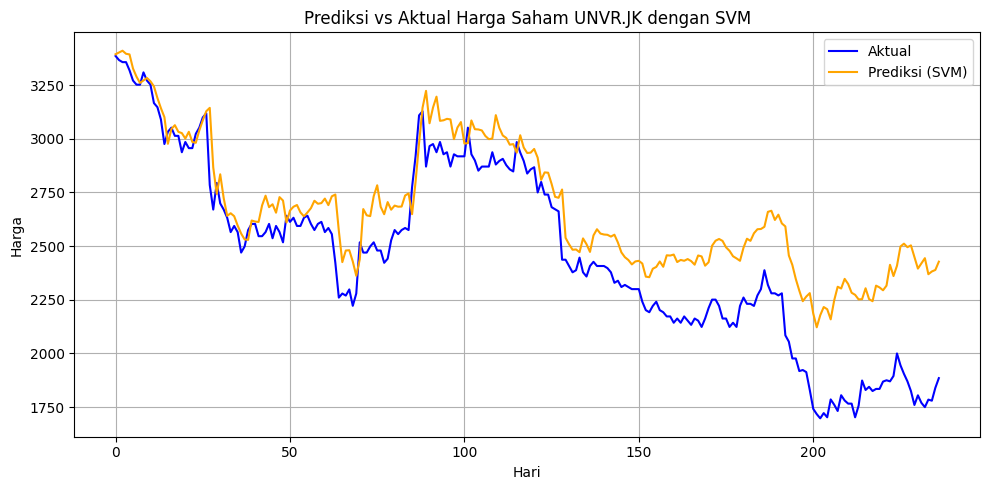

In [ ]:
actual_full = data[ticker].dropna().values.reshape(-1, 1)
actual_cut = actual_full[-len(y_pred_actual):]

plt.figure(figsize=(10, 5))
plt.plot(actual_cut, label='Aktual', color='blue')
plt.plot(y_pred_actual, label='Prediksi (SVM)', color='orange')
plt.title(f'Prediksi vs Aktual Harga Saham {ticker} dengan SVM')
plt.xlabel('Hari')
plt.ylabel('Harga')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()